In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
bigp = ['AL', 'BNP', 'Jamaat', 'JaPa']
mainp = ['AL', 'BNP']
years = [1991, 1996, 2001, 2008]

In [3]:
dfc = pd.read_csv('data/candidate_result.csv')
dfc.head()

,seat,year,party,name,votes,votes_pc,winner
0,Dhaka-3,2008,BNP,Gayeshwar Chandra Roy,70680.0,36.71,no
1,Dhaka-6,1991,Independent,Sayed Sharafat Hossain,8.0,0.01,no
2,Dhaka-6,1991,Jatiya Janata Party (Asad),Md. Afzalul Huq Afzal,9.0,0.01,no
3,Comilla-3,2001,Independent,Md. Ainul Haque,12.0,0.01,no
4,Dhaka-5,1991,Jatiyatabadi Gonotantrik Chashi Dal,Afzaluddin Chowdhury,14.0,0.01,no


In [4]:
dfc.shape

(8747, 7)

In [5]:
# only take 1991-2008 election data
dfc = dfc[dfc.year.isin(years)]
dfc.shape

(8183, 7)

In [6]:
dfs = pd.read_csv('data/seat_summary.csv')
dfs.head()

,seat,year,turnout,turnout_pc,voters
0,Panchagarh-1,2024,192579.0,44.08,436923.0
1,Panchagarh-1,2018,320597.0,84.54,379207.0
2,Panchagarh-1,2014,86046.0,26.16,328959.0
3,Panchagarh-1,2008,266812.0,91.70,291095.0
4,Panchagarh-1,2001,206827.0,86.15,240073.0


In [7]:
dfg_seat_year = dfc.groupby(['seat', 'year'])

vdiffpc_data = []

# find vote difference in % between top 2 candidates of each seat each year
for gcols, dfg in dfg_seat_year:
    # for a given seat and year, get vote counts of top 2 candidates 
    dftop2 = dfg.sort_values(by=['votes'], ascending=False).head(2)
    if len(dftop2) < 2:
        continue
    # get winner and loser data
    winner = dftop2.iloc[0]
    loser = dftop2.iloc[1]
    if winner.winner != 'yes':
        continue
    if loser.winner == 'yes':
        continue
    # find vote difference
    vdiff = winner.votes - loser.votes
    seat, year = gcols
    # get turnout number for a given seat and year
    turnout = dfs[(dfs.seat == seat) & (dfs.year == year)].head(1)['turnout'].to_list()
    if len(turnout) < 1 or np.isnan(turnout[0]):
        continue
    # find vote difference in % with respect to turnout
    vdiffpc = round(vdiff / int(turnout[0]) * 100, 2)
    vdiffpc_data.append((seat, year, winner.party, loser.party, vdiffpc))
    
dfvdpc = pd.DataFrame(vdiffpc_data, columns=['seat', 'year', 'party_won', 'party_lost', 'vdiff_pc'])
dfvdpc.head()

,seat,year,party_won,party_lost,vdiff_pc
0,Bagerhat-1,1991,AL,BNP,17.01
1,Bagerhat-1,1996,AL,BNP,19.95
2,Bagerhat-1,2001,AL,BNP,12.32
3,Bagerhat-1,2008,AL,BNP,40.34
4,Bagerhat-2,1991,BNP,AL,1.12


In [8]:
# only keep close contest (vote difference less than 10%)
dfcc = dfvdpc[dfvdpc.vdiff_pc <= 10].copy()
dfcc.head()

,seat,year,party_won,party_lost,vdiff_pc
4,Bagerhat-2,1991,BNP,AL,1.12
5,Bagerhat-2,1996,AL,BNP,4.05
7,Bagerhat-2,2008,AL,BNP,3.86
10,Bagerhat-3,2001,AL,Jamaat,4.95
16,Barguna-2,1991,Independent,AL,8.48


In [9]:
# find number of seats won by big parties each year through close contest
dfccwon = dfcc.groupby(['year', 'party_won']).size().unstack(fill_value=0)[bigp]
dfccwon.head()

party_won,AL,BNP,Jamaat,JaPa
year,,,,
1991,35,56,10,20
1996,76,49,3,18
2001,30,63,5,0
2008,50,12,1,5


In [10]:
dfccwon.to_csv('dataout/bigp_cc_win_count.csv')

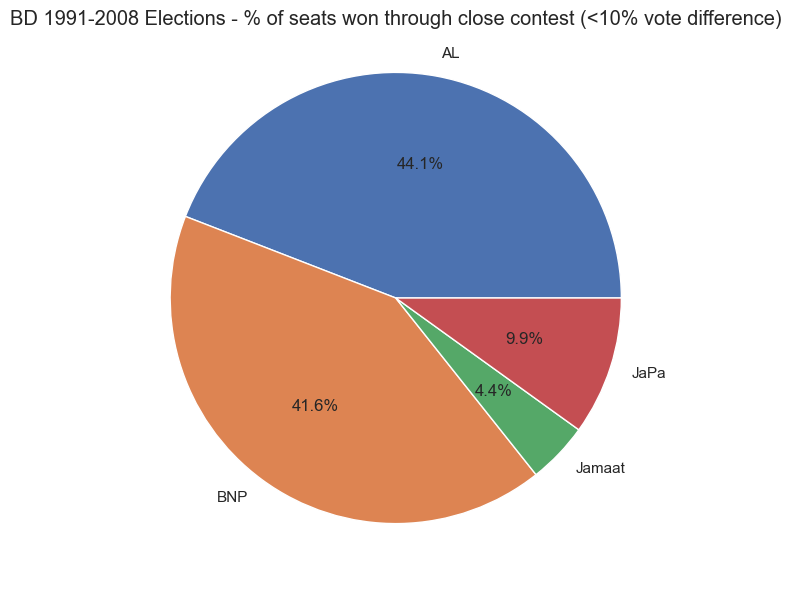

In [14]:
# plot % of seats won through close contest by each of the big parties
dfccwon_sums = dfccwon[bigp].sum()

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(dfccwon_sums, labels=bigp, autopct='%1.1f%%')        
fig.tight_layout()
plt.suptitle('BD 1991-2008 Elections - % of seats won through close contest (<10% vote difference)')
fig.savefig('fig/bigp_cc_win_pc',bbox_inches='tight')
plt.show()

In [16]:
# find number of seats lost by big parties each year through close contest
dfcclost = dfcc.groupby(['year', 'party_lost']).size().unstack(fill_value=0)[bigp]
dfcclost.head()

party_lost,AL,BNP,Jamaat,JaPa
year,,,,
1991,65,26,14,10
1996,59,65,4,20
2001,76,26,3,0
2008,12,42,11,4


In [17]:
dfcclost.to_csv('dataout/bigp_cc_lose_count.csv')

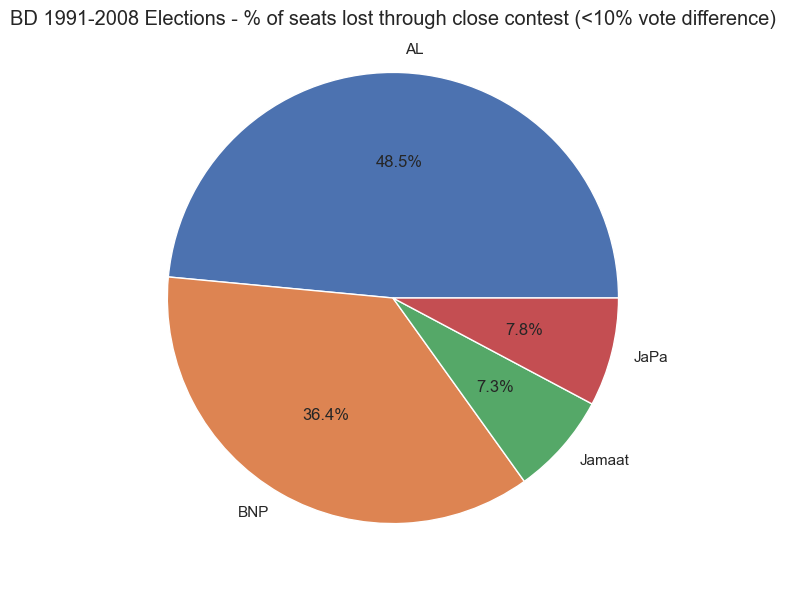

In [18]:
# plot % of seats lost through close contest by each of the big parties
dfcclost_sums = dfcclost[bigp].sum()

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(dfcclost_sums, labels=bigp, autopct='%1.1f%%')        
fig.tight_layout()
plt.suptitle('BD 1991-2008 Elections - % of seats lost through close contest (<10% vote difference)')
fig.savefig('fig/bigp_cc_lose_pc',bbox_inches='tight')
plt.show()

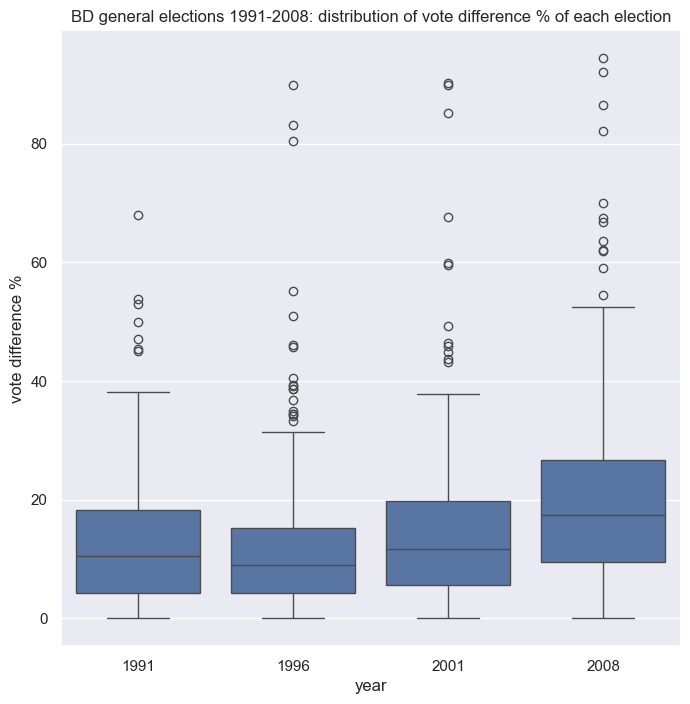

In [16]:
# vote difference % distribution
fig, ax = plt.subplots(figsize=(8, 8))
sns.boxplot(x='year', y='vdiff_pc', data=dfvdpc, ax=ax)
ax.set_title('BD general elections 1991-2008: distribution of vote difference % of each election')
ax.set_ylabel('vote difference %')
fig.savefig('fig/vdiff_dist',bbox_inches='tight')